In [ ]:
!pip install rdkit
!pip install umap-learn
!pip install hdbscan
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install numpy

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving data_loaders.py to data_loaders.py


In [ ]:
!pip install torch
!pip install torch_geometric

In [ ]:
from data_loaders import preproccess_data
file_path = "/content/drive/MyDrive/BioSolveAI/data/curated-solubility-dataset.csv"

df = preproccess_data(file_path)

In [ ]:
# shape should be (9959, 27) as seen in EDA file
assert df.shape == (9959, 27)

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors
from rdkit.Chem.GraphDescriptors import BertzCT, BalabanJ

# get first molecule and its name
mol = df.loc[1, "mol"]
name = df.loc[1, "Name"]

# compute molecular descriptors (global features)
features = {
    "name": name,
    "MolWt": Descriptors.MolWt(mol),
    "MolLogP": Crippen.MolLogP(mol),
    "TPSA": rdMolDescriptors.CalcTPSA(mol),
    "BalabanJ": float(BalabanJ(mol)),
    "MolMR": Crippen.MolMR(mol),
    "BertzCT": BertzCT(mol)
}

# ensuring each of the rdkit descriptors are functioning
print(features)

{'name': 'Benzo[cd]indol-2(1H)-one', 'MolWt': 169.18299999999996, 'MolLogP': 2.405500000000001, 'TPSA': 29.1, 'BalabanJ': 2.5829963936570306, 'MolMR': 51.90120000000002, 'BertzCT': 511.2292477154967}


O=C1Nc2cccc3cccc1c23
tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0]]) 
 torch.Size([13, 13])
Edge index shape: torch.Size([2, 30])
Edge index:
 tensor([[ 0,  1,  1,  1,  2,  2,  3,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  7,
          8,  8,  9,  9, 10, 10, 11, 11, 11, 12, 12, 12],
        [ 1,  0,  2, 11,  1,  3,  2,  4, 12,  3,  5,  4,  6,  5,  7,  6,  8, 12,
          7,  9,  8, 10,  9, 11,  1, 10, 12,  3

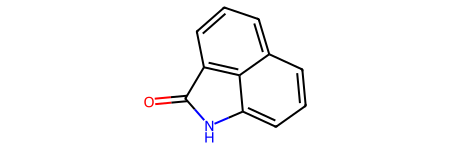

In [ ]:
import rdkit
from rdkit import Chem
from rdkit.Chem import rdmolops
from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors
from rdkit.Chem.GraphDescriptors import BertzCT, BalabanJ
import torch
from torch_geometric.data import Data

smiles = df.loc[1, 'SMILES']
print(smiles)
mol = Chem.MolFromSmiles(smiles)

# get adjacency matrix and convert to torch tensor
adj = rdmolops.GetAdjacencyMatrix(mol)
adj = torch.tensor(adj, dtype=torch.long)
print(adj, "\n", adj.shape)

# convert to edge_index format used in PyTorch Geometric
edge_index = adj.nonzero(as_tuple=False).t().contiguous()

# check that adjacency matrix is working properly
print("Edge index shape:", edge_index.shape)
print("Edge index:\n", edge_index)
display(mol)

# assert basic logic, edge shape should be 2 x num bonds
# and adjacency dim should be number of atoms
assert edge_index.shape[1] == adj.sum() == 2 * mol.GetNumBonds()
assert edge_index.shape[0] == 2
assert adj.shape[0] == adj.shape[1] == mol.GetNumAtoms()

In [ ]:
# check node features, selected 6 basic atomic features from rdkit taht impact solubility
name = df.loc[1, "Name"]
print(name)
atom_features = []
for atom in mol.GetAtoms():
  atom_features.append([
      atom.GetAtomicNum(),
      atom.GetIsAromatic(),
      atom.GetDegree(),
      atom.GetFormalCharge(),
      atom.GetTotalNumHs(),
      atom.IsInRing()
    ])
x = torch.tensor(atom_features, dtype=torch.float)

print(x, "\n", x.shape)

assert x.shape[0] == mol.GetNumAtoms()
assert x.shape[1] == 6

mol1 = df.loc[2045, "mol"]
name = df.loc[2045, "Name"]
print(name)

atom_features = []
for atom in mol1.GetAtoms():
  atom_features.append([
      atom.GetAtomicNum(),
      atom.GetIsAromatic(),
      atom.GetDegree(),
      atom.GetFormalCharge(),
      atom.GetTotalNumHs(),
      atom.IsInRing()
    ])
x = torch.tensor(atom_features, dtype=torch.float)

assert x.shape[0] == mol1.GetNumAtoms()
assert x.shape[1] == 6

print(x, "\n", x.shape)

Benzo[cd]indol-2(1H)-one
tensor([[8., 0., 1., 0., 0., 0.],
        [6., 0., 3., 0., 0., 1.],
        [7., 0., 2., 0., 1., 1.],
        [6., 1., 3., 0., 0., 1.],
        [6., 1., 2., 0., 1., 1.],
        [6., 1., 2., 0., 1., 1.],
        [6., 1., 2., 0., 1., 1.],
        [6., 1., 3., 0., 0., 1.],
        [6., 1., 2., 0., 1., 1.],
        [6., 1., 2., 0., 1., 1.],
        [6., 1., 2., 0., 1., 1.],
        [6., 1., 3., 0., 0., 1.],
        [6., 1., 3., 0., 0., 1.]]) 
 torch.Size([13, 6])
acetic acid
tensor([[6., 0., 1., 0., 3., 0.],
        [6., 0., 3., 0., 0., 0.],
        [8., 0., 1., 0., 0., 0.],
        [8., 0., 1., 0., 1., 0.]]) 
 torch.Size([4, 6])


In [ ]:
bond_type_to_idx = {
    Chem.rdchem.BondType.SINGLE: 0,
    Chem.rdchem.BondType.DOUBLE: 1,
    Chem.rdchem.BondType.TRIPLE: 2,
    Chem.rdchem.BondType.AROMATIC: 3,
  }

edge_attr = []
for bond in mol.GetBonds():
  i = bond.GetBeginAtomIdx()
  j = bond.GetEndAtomIdx()
  bond_type = bond.GetBondType()
  bond_feature = [0] * len(bond_type_to_idx)
  bond_feature[bond_type_to_idx[bond_type]] = 1

  # add edge in both directions (since PyG treats edges as undirected by default)
  edge_attr.append(bond_feature)
  edge_attr.append(bond_feature)

edge_attr = torch.tensor(edge_attr, dtype=torch.float)
print(edge_attr, "\n", edge_attr.shape)

assert edge_attr.shape[0] == 2 * mol.GetNumBonds()
assert edge_attr.shape[1] == len(bond_type_to_idx)
assert torch.all(edge_attr.sum(dim=1) == 1.0)

tensor([[0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]]) 
 torch.Size([30, 4])


In [ ]:
from data_loaders import mol_to_graph

mol = df.loc[1, "mol"]
data = mol_to_graph(mol)
targets = df['Solubility'].tolist()
target = targets[0]
data.y = torch.tensor([target], dtype=torch.float)

In [ ]:
print(data.x)
print(data.edge_index)
print(data.edge_attr)
print(data.u)
print(data.y)

tensor([[8., 0., 1., 0., 0., 0.],
        [6., 0., 3., 0., 0., 1.],
        [7., 0., 2., 0., 1., 1.],
        [6., 1., 3., 0., 0., 1.],
        [6., 1., 2., 0., 1., 1.],
        [6., 1., 2., 0., 1., 1.],
        [6., 1., 2., 0., 1., 1.],
        [6., 1., 3., 0., 0., 1.],
        [6., 1., 2., 0., 1., 1.],
        [6., 1., 2., 0., 1., 1.],
        [6., 1., 2., 0., 1., 1.],
        [6., 1., 3., 0., 0., 1.],
        [6., 1., 3., 0., 0., 1.]])
tensor([[ 0,  1,  1,  1,  2,  2,  3,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  7,
          8,  8,  9,  9, 10, 10, 11, 11, 11, 12, 12, 12],
        [ 1,  0,  2, 11,  1,  3,  2,  4, 12,  3,  5,  4,  6,  5,  7,  6,  8, 12,
          7,  9,  8, 10,  9, 11,  1, 10, 12,  3,  7, 11]])
tensor([[0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0

In [ ]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
from torch_geometric.loader import DataLoader

targets = df['Solubility'].tolist()
mols = df['mol'].tolist()

graph_data_list = []
for mol, target in zip(mols, targets):
    data = mol_to_graph(mol)
    data.y = torch.tensor([target], dtype=torch.float).unsqueeze(0)
    graph_data_list.append(data)

loader = DataLoader(graph_data_list, batch_size=1, shuffle=True)
batch = next(iter(loader))
print(batch)

DataBatch(x=[11, 6], edge_index=[2, 22], edge_attr=[22, 4], u=[1, 6], y=[1, 1], batch=[11], ptr=[2])


In [50]:
# generate scaffold splits, building off of EDA file
from rdkit.Chem.Scaffolds import MurckoScaffold

def get_scaffolds(mol):
    try:
        scaffold = MurckoScaffold.GetScaffoldForMol(mol)
        if scaffold.GetNumAtoms() == 0:
            return Chem.MolToSmiles(mol)
        return Chem.MolToSmiles(scaffold)
    except:
        return Chem.MolToSmiles(mol)

df['scaffold'] = df['mol'].apply(get_scaffolds)

In [51]:
df.shape

(9959, 28)

In [52]:
from collections import defaultdict
import numpy as np

def generate_scaffold_split(df, frac_train=0.8, frac_valid=0.1, frac_test=0.1, seed=42):
    # group scaffolds
    scaffold_to_indices = defaultdict(list)
    for idx, scaffold in enumerate(df['scaffold']):
        scaffold_to_indices[scaffold].append(idx)

    # sort scaffolds by group size
    sorted_scaffold_groups = sorted(scaffold_to_indices.values(), key=len, reverse=True)

    # split into train/val/test by scaffold group
    train_idx, val_idx, test_idx = [], [], []
    total = len(df)
    np.random.seed(seed)

    for group in sorted_scaffold_groups:
        if len(train_idx) + len(group) <= frac_train * total:
            train_idx.extend(group)
        elif len(val_idx) + len(group) <= frac_valid * total:
            val_idx.extend(group)
        else:
            test_idx.extend(group)

    return train_idx, val_idx, test_idx

train_idx, val_idx, test_idx = generate_scaffold_split(df)

# Create splits
train_df = df.iloc[train_idx]
val_df = df.iloc[val_idx]
test_df = df.iloc[test_idx]

In [53]:
print(train_df.shape, val_df.shape, test_df.shape)

# distinc scaffolds in each set
train_scaffolds = len(set(train_df['scaffold']))
val_scaffolds = len(set(val_df['scaffold']))
test_scaffolds = len(set(test_df['scaffold']))

# total unique scaffolds (should be 4991)
total_unique = df['scaffold'].nunique()

print(f"Train: {train_scaffolds} scaffolds")
print(f"Val: {val_scaffolds} scaffolds")
print(f"Test: {test_scaffolds} scaffolds")
print(f"Sum: {train_scaffolds + val_scaffolds + test_scaffolds} scaffolds")
print(f"Total unique scaffolds in dataset: {total_unique}")


(7967, 28) (995, 28) (997, 28)
Train: 2999 scaffolds
Val: 995 scaffolds
Test: 997 scaffolds
Sum: 4991 scaffolds
Total unique scaffolds in dataset: 4991
